# Import IgLM

In [1]:
from iglm import IgLM
from anarci import anarci

from functools import reduce
from operator import concat
import numpy as np
import pickle
import collections
import matplotlib.pyplot as plt

iglm = IgLM()

# Generate Sequences

In [2]:
# Generate full sequences (no camel)

chain_tokens = ["[HEAVY]", "[LIGHT]"]
species_tokens = ["[HUMAN]", "[MOUSE]", "[RABBIT]", "[RAT]", "[RHESUS]"]
prompt_sequence = [["EVQ","QSA","DIQ"], ["QVQ","QAV","DIV"], ["QEQ","QPA","ALV"], ["EVQ","QAV","GIQ"], ["QVQ","QSV","AIQ"]]
temperature = [0.6, 0.8, 1.0, 1.2]
num_seqs = [2000, 1000]

generated_seqs = []
names = []
for t in temperature:
    for i in species_tokens:
        for j in chain_tokens:
            if j == "[HEAVY]":
                generated_seqs.append(iglm.generate(j, i, 
                                    prompt_sequence=prompt_sequence[species_tokens.index(i)][chain_tokens.index(j)], 
                                    num_to_generate=num_seqs[0], temperature=t))
                for m in range(num_seqs[0]):
                    names.append(f"{i}{m}:{t}:H")
            else:     
                for k in range(1,3,1):
                    generated_seqs.append(iglm.generate(j, i, 
                                        prompt_sequence=prompt_sequence[species_tokens.index(i)][k], 
                                        num_to_generate=num_seqs[1], temperature=t))
                for m in range(2*num_seqs[1]):
                    if m < num_seqs[1]:
                        names.append(f"{i}{m}:{t}:L")
                    else:
                        m -= num_seqs[1]
                        names.append(f"{i}{m}:{t}:K")

    # Add camel sequence
    generated_seqs.append(iglm.generate("[HEAVY]", "[CAMEL]", 
                        prompt_sequence="QVQ", num_to_generate=num_seqs[0], temperature=t))

    for m in range(num_seqs[0]):
        names.append(f"[CAMEL]{m}:{t}:H")

100%|███████████████████████████████████████| 2000/2000 [25:28<00:00,  1.31it/s]


# Analysis

In [36]:
flattened_seqs = reduce(concat, generated_seqs)

In [38]:
anarci_sequences = []
for i in range(len(flattened_seqs)):
    anarci_sequences.append((names[i], flattened_seqs[i]))

In [39]:
results = anarci(anarci_sequences, scheme="imgt", output=False)
numbering, alignment_details, hit_tables = results

In [35]:
# Save the generated_seqs list
file_name = "generated_seqs.pkl"

open_file = open(file_name, "wb")
pickle.dump(generated_seqs, open_file)
open_file.close()


# Save the names list
file_name = "names.pkl"

open_file = open(file_name, "wb")
pickle.dump(names, open_file)
open_file.close()


# Save the flattened_seqs list
file_name = "flattened_seqs.pkl"

open_file = open(file_name, "wb")
pickle.dump(flattened_seqs, open_file)
open_file.close()


# Save the anarci results
file_name = "anarci_res.pkl"

open_file = open(file_name, "wb")
pickle.dump(results, open_file)
open_file.close()

In [ ]:
# Reopen lists
# open_file = open(file_name, "rb")
# loaded_seqs = pickle.load(open_file)
# open_file.close()

# print(loaded_seqs[0])

## Checking for partial match: species ONLY

In [566]:
label = []
for i in range(len(flattened_seqs)):
    if numbering[i] is None:
        label.append(np.nan)
    else:
        label.append(alignment_details[i][0].get("id"))

In [685]:
# Initialize different species types

human_H = []
human_L = []

mouse_H = []
mouse_L = []

alpaca_H = []

rabbit_H = []
rabbit_L = []

pig_H = []
pig_L = []

rhesus_H = []
rhesus_L = []

cow_H = []
cow_L = []

rat_H = []
rat_L = []


# Organize by tokens
chain_tokens = ['H', 'L']
species_tokens = ["[HUMAN]", "[MOUSE]", "[CAMEL]", "[RABBIT]", "[RAT]", "[RHESUS]"]

for i in species_tokens:
    for j in chain_tokens:
        human = np.zeros(4)
        mouse = np.zeros(4)
        alpaca = np.zeros(4)
        rabbit = np.zeros(4)
        pig = np.zeros(4)
        rhesus = np.zeros(4)
        cow = np.zeros(4)
        rat = np.zeros(4)
        for t in temperature:
            
            keys = []
            
            if j == 'H':
                start = names.index(f"{i}0:{t}:{j}")
                end = names.index(f"{i}1999:{t}:{j}")
                
                # getting the elements frequencies using Counter class
                elements_count = collections.Counter(label[start:end])
                vals = np.fromiter(elements_count.values(), dtype=int)
                
                for key in elements_count.keys():
                    if type(key) != float:
                        keys.append(key)
                    else:
                        continue
                
                for k in range(len(keys)):
                    keys[k] = keys[k][0:-2]
                    
                for s in set(keys):
                    indices = [i for i, x in enumerate(keys) if x == s]
                    if s == 'human':
                        human[temperature.index(t)] = (sum(vals[indices]) / sum(vals)) * 100
                    elif s == 'mouse':
                        mouse[temperature.index(t)] = (sum(vals[indices]) / sum(vals)) * 100
                    elif s == 'alpaca':
                        alpaca[temperature.index(t)] = (sum(vals[indices]) / sum(vals)) * 100
                    elif s == 'rabbit':
                        rabbit[temperature.index(t)] = (sum(vals[indices]) / sum(vals)) * 100
                    elif s == 'pig':
                        pig[temperature.index(t)] = (sum(vals[indices]) / sum(vals)) * 100
                    elif s == 'rhesus':
                        rhesus[temperature.index(t)] = (sum(vals[indices]) / sum(vals)) * 100
                    elif s == 'cow':
                        cow[temperature.index(t)] = (sum(vals[indices]) / sum(vals)) * 100
                    elif s == 'rat':
                        rat[temperature.index(t)] = (sum(vals[indices]) / sum(vals)) * 100
                    
            else:
                if i == "[CAMEL]":
                    continue
                else:
                    start = names.index(f"{i}0:{t}:{j}")
                    end = names.index(f"{i}999:{t}:K")
                
                    # getting the elements frequencies using Counter class
                    elements_count = collections.Counter(label[start:end])
                    vals = np.fromiter(elements_count.values(), dtype=int)
                    for key in elements_count.keys():
                        if type(key) != float:
                            keys.append(key)
                        else:
                            continue
                    for k in range(len(keys)):
                        keys[k] = keys[k][0:-2]
                
                    for s in set(keys):
                        indices = [i for i, x in enumerate(keys) if x == s]
                        if s == 'human':
                            human[temperature.index(t)] = (sum(vals[indices]) / sum(vals)) * 100
                        elif s == 'mouse':
                            mouse[temperature.index(t)] = (sum(vals[indices]) / sum(vals)) * 100
                        elif s == 'alpaca':
                            alpaca[temperature.index(t)] = (sum(vals[indices]) / sum(vals)) * 100
                        elif s == 'rabbit':
                            rabbit[temperature.index(t)] = (sum(vals[indices]) / sum(vals)) * 100
                        elif s == 'pig':
                            pig[temperature.index(t)] = (sum(vals[indices]) / sum(vals)) * 100
                        elif s == 'rhesus':
                            rhesus[temperature.index(t)] = (sum(vals[indices]) / sum(vals)) * 100
                        elif s == 'cow':
                            cow[temperature.index(t)] = (sum(vals[indices]) / sum(vals)) * 100
                        elif s == 'rat':
                            rat[temperature.index(t)] = (sum(vals[indices]) / sum(vals)) * 100
            
        if j == 'H':
            human_H.append(human)
            mouse_H.append(mouse)
            alpaca_H.append(alpaca)
            rabbit_H.append(rabbit)
            pig_H.append(pig)
            rhesus_H.append(rhesus)
            cow_H.append(cow)
            rat_H.append(rat)
        else:
            human_L.append(human)
            mouse_L.append(mouse)
            rabbit_L.append(rabbit)
            pig_L.append(pig)
            rhesus_L.append(rhesus)
            cow_L.append(cow)
            rat_L.append(rat)

In [693]:
human_H

[array([ 2.45122561,  5.85292646,  9.15457729, 13.35667834]),
 array([0.05002501, 0.75037519, 0.8004002 , 2.60130065]),
 array([0.       , 0.       , 0.       , 0.4002001]),
 array([0., 0., 0., 0.]),
 array([0.        , 0.        , 0.05002501, 0.25012506]),
 array([34.66733367, 32.66633317, 30.71535768, 36.46823412])]

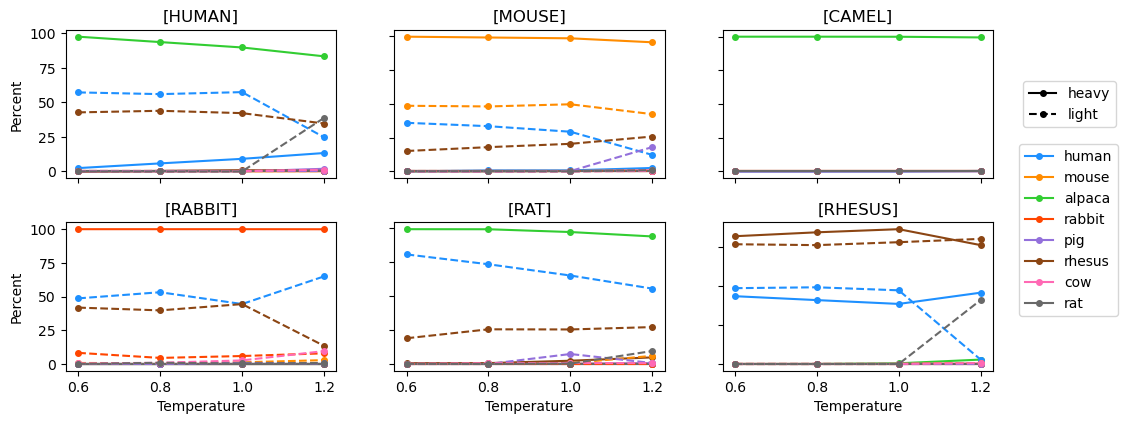

In [686]:
fig, axs = plt.subplots(2, 3, figsize=(10,4))
fig.tight_layout()

# [HUMAN] conditioning tag

# [HEAVY] conditioning tag
axs[0, 0].plot(temperature, human_H[0], marker='o', markersize=4, color='dodgerblue', label='human')
axs[0, 0].plot(temperature, mouse_H[0], marker='o', markersize=4, color='darkorange', label='mouse')
axs[0, 0].plot(temperature, alpaca_H[0], marker='o', markersize=4, color='limegreen', label='alpaca')
axs[0, 0].plot(temperature, rabbit_H[0], marker='o', markersize=4, color='orangered', label='rabbit')
axs[0, 0].plot(temperature, pig_H[0], marker='o', markersize=4, color='mediumpurple', label='pig')
axs[0, 0].plot(temperature, rhesus_H[0], marker='o', markersize=4, color='saddlebrown', label='rhesus')
axs[0, 0].plot(temperature, cow_H[0], marker='o', markersize=4, color='hotpink', label='cow')
axs[0, 0].plot(temperature, rat_H[0], marker='o', markersize=4, color='dimgrey', label='rat')

# [LIGHT] conditioning tag
axs[0, 0].plot(temperature, human_L[0], marker='o', markersize=4, linestyle='dashed', color='dodgerblue')
axs[0, 0].plot(temperature, mouse_L[0], marker='o', markersize=4, linestyle='dashed', color='darkorange')
axs[0, 0].plot(temperature, rabbit_L[0], marker='o', markersize=4, linestyle='dashed', color='orangered')
axs[0, 0].plot(temperature, pig_L[0], marker='o', markersize=4, linestyle='dashed', color='mediumpurple')
axs[0, 0].plot(temperature, rhesus_L[0], marker='o', markersize=4, linestyle='dashed', color='saddlebrown')
axs[0, 0].plot(temperature, cow_L[0], marker='o', markersize=4, linestyle='dashed', color='hotpink')
axs[0, 0].plot(temperature, rat_L[0], marker='o', markersize=4, linestyle='dashed', color='dimgrey')

axs[0, 0].set_title('[HUMAN]')
axs[0, 0].set_xticks([0.6, 0.8, 1.0, 1.2])


# [MOUSE] conditioning tag

# [HEAVY] conditioning tag
axs[0, 1].plot(temperature, human_H[1], marker='o', markersize=4, color='dodgerblue')
axs[0, 1].plot(temperature, mouse_H[1], marker='o', markersize=4, color='darkorange')
axs[0, 1].plot(temperature, alpaca_H[1], marker='o', markersize=4, color='limegreen')
axs[0, 1].plot(temperature, rabbit_H[1], marker='o', markersize=4, color='orangered')
axs[0, 1].plot(temperature, pig_H[1], marker='o', markersize=4, color='mediumpurple')
axs[0, 1].plot(temperature, rhesus_H[1], marker='o', markersize=4, color='saddlebrown')
axs[0, 1].plot(temperature, cow_H[1], marker='o', markersize=4, color='hotpink')
axs[0, 1].plot(temperature, rat_H[1], marker='o', markersize=4, color='dimgrey')

# [LIGHT] conditioning tag
axs[0, 1].plot(temperature, human_L[1], marker='o', markersize=4, linestyle='dashed', color='dodgerblue')
axs[0, 1].plot(temperature, mouse_L[1], marker='o', markersize=4, linestyle='dashed', color='darkorange')
axs[0, 1].plot(temperature, rabbit_L[1], marker='o', markersize=4, linestyle='dashed', color='orangered')
axs[0, 1].plot(temperature, pig_L[1], marker='o', markersize=4, linestyle='dashed', color='mediumpurple')
axs[0, 1].plot(temperature, rhesus_L[1], marker='o', markersize=4, linestyle='dashed', color='saddlebrown')
axs[0, 1].plot(temperature, cow_L[1], marker='o', markersize=4, linestyle='dashed', color='hotpink')
axs[0, 1].plot(temperature, rat_L[1], marker='o', markersize=4, linestyle='dashed', color='dimgrey')

axs[0, 1].set_title('[MOUSE]')
axs[0, 1].set_xticks([0.6, 0.8, 1.0, 1.2])

dummy_lines = []
dummy_lines.append(axs[0, 1].plot([],[], c="black", marker='o', markersize=4, ls = '-', label='heavy')[0]) 
dummy_lines.append(axs[0, 1].plot([],[], c="black", marker='o', markersize=4, ls = '--', label='light')[0])                            


# [CAMEL] conditioning tag

# [HEAVY] conditioning tag
axs[0, 2].plot(temperature, human_H[2], marker='o', markersize=4, color='dodgerblue')
axs[0, 2].plot(temperature, mouse_H[2], marker='o', markersize=4, color='darkorange')
axs[0, 2].plot(temperature, alpaca_H[2], marker='o', markersize=4, color='limegreen')
axs[0, 2].plot(temperature, rabbit_H[2], marker='o', markersize=4, color='orangered')
axs[0, 2].plot(temperature, pig_H[2], marker='o', markersize=4, color='mediumpurple')
axs[0, 2].plot(temperature, rhesus_H[2], marker='o', markersize=4, color='saddlebrown')
axs[0, 2].plot(temperature, cow_H[2], marker='o', markersize=4, color='hotpink')
axs[0, 2].plot(temperature, rat_H[2], marker='o', markersize=4, color='dimgrey')

axs[0, 2].set_title('[CAMEL]')
axs[0, 2].set_xticks([0.6, 0.8, 1.0, 1.2])


# [RABBIT] conditioning tag

# [HEAVY] conditioning tag
axs[1, 0].plot(temperature, human_H[3], marker='o', markersize=4, color='dodgerblue')
axs[1, 0].plot(temperature, mouse_H[3], marker='o', markersize=4, color='darkorange')
axs[1, 0].plot(temperature, alpaca_H[3], marker='o', markersize=4, color='limegreen')
axs[1, 0].plot(temperature, rabbit_H[3], marker='o', markersize=4, color='orangered')
axs[1, 0].plot(temperature, pig_H[3], marker='o', markersize=4, color='mediumpurple')
axs[1, 0].plot(temperature, rhesus_H[3], marker='o', markersize=4, color='saddlebrown')
axs[1, 0].plot(temperature, cow_H[3], marker='o', markersize=4, color='hotpink')
axs[1, 0].plot(temperature, rat_H[3], marker='o', markersize=4, color='dimgrey')

# [LIGHT] conditioning tag
axs[1, 0].plot(temperature, human_L[3], marker='o', markersize=4, linestyle='dashed', color='dodgerblue')
axs[1, 0].plot(temperature, mouse_L[3], marker='o', markersize=4, linestyle='dashed', color='darkorange')
axs[1, 0].plot(temperature, rabbit_L[3], marker='o', markersize=4, linestyle='dashed', color='orangered')
axs[1, 0].plot(temperature, pig_L[3], marker='o', markersize=4, linestyle='dashed', color='mediumpurple')
axs[1, 0].plot(temperature, rhesus_L[3], marker='o', markersize=4, linestyle='dashed', color='saddlebrown')
axs[1, 0].plot(temperature, cow_L[3], marker='o', markersize=4, linestyle='dashed', color='hotpink')
axs[1, 0].plot(temperature, rat_L[3], marker='o', markersize=4, linestyle='dashed', color='dimgrey')

axs[1, 0].set_title('[RABBIT]')
axs[1, 0].set_xticks([0.6, 0.8, 1.0, 1.2])


# [RAT] conditioning tag

# [HEAVY] conditioning tag
axs[1, 1].plot(temperature, human_H[4], marker='o', markersize=4, color='dodgerblue')
axs[1, 1].plot(temperature, mouse_H[4], marker='o', markersize=4, color='darkorange')
axs[1, 1].plot(temperature, alpaca_H[4], marker='o', markersize=4, color='limegreen')
axs[1, 1].plot(temperature, rabbit_H[4], marker='o', markersize=4, color='orangered')
axs[1, 1].plot(temperature, pig_H[4], marker='o', markersize=4, color='mediumpurple')
axs[1, 1].plot(temperature, rhesus_H[4], marker='o', markersize=4, color='saddlebrown')
axs[1, 1].plot(temperature, cow_H[4], marker='o', markersize=4, color='hotpink')
axs[1, 1].plot(temperature, rat_H[4], marker='o', markersize=4, color='dimgrey')

# [LIGHT] conditioning tag
axs[1, 1].plot(temperature, human_L[4], marker='o', markersize=4, linestyle='dashed', color='dodgerblue')
axs[1, 1].plot(temperature, mouse_L[4], marker='o', markersize=4, linestyle='dashed', color='darkorange')
axs[1, 1].plot(temperature, rabbit_L[4], marker='o', markersize=4, linestyle='dashed', color='orangered')
axs[1, 1].plot(temperature, pig_L[4], marker='o', markersize=4, linestyle='dashed', color='mediumpurple')
axs[1, 1].plot(temperature, rhesus_L[4], marker='o', markersize=4, linestyle='dashed', color='saddlebrown')
axs[1, 1].plot(temperature, cow_L[4], marker='o', markersize=4, linestyle='dashed', color='hotpink')
axs[1, 1].plot(temperature, rat_L[4], marker='o', markersize=4, linestyle='dashed', color='dimgrey')

axs[1, 1].set_title('[RAT]')
axs[1, 1].set_xticks([0.6, 0.8, 1.0, 1.2])


# [RHESUS] conditioning tag

# [HEAVY] conditioning tag
axs[1, 2].plot(temperature, human_H[5], marker='o', markersize=4, color='dodgerblue')
axs[1, 2].plot(temperature, mouse_H[5], marker='o', markersize=4, color='darkorange')
axs[1, 2].plot(temperature, alpaca_H[5], marker='o', markersize=4, color='limegreen')
axs[1, 2].plot(temperature, rabbit_H[5], marker='o', markersize=4, color='orangered')
axs[1, 2].plot(temperature, pig_H[5], marker='o', markersize=4, color='mediumpurple')
axs[1, 2].plot(temperature, rhesus_H[5], marker='o', markersize=4, color='saddlebrown')
axs[1, 2].plot(temperature, cow_H[5], marker='o', markersize=4, color='hotpink')
axs[1, 2].plot(temperature, rat_H[5], marker='o', markersize=4, color='dimgrey')

# [LIGHT] conditioning tag
axs[1, 2].plot(temperature, human_L[5], marker='o', markersize=4, linestyle='dashed', color='dodgerblue')
axs[1, 2].plot(temperature, mouse_L[5], marker='o', markersize=4, linestyle='dashed', color='darkorange')
axs[1, 2].plot(temperature, rabbit_L[5], marker='o', markersize=4, linestyle='dashed', color='orangered')
axs[1, 2].plot(temperature, pig_L[5], marker='o', markersize=4, linestyle='dashed', color='mediumpurple')
axs[1, 2].plot(temperature, rhesus_L[5], marker='o', markersize=4, linestyle='dashed', color='saddlebrown')
axs[1, 2].plot(temperature, cow_L[5], marker='o', markersize=4, linestyle='dashed', color='hotpink')
axs[1, 2].plot(temperature, rat_L[5], marker='o', markersize=4, linestyle='dashed', color='dimgrey')

axs[1, 2].set_title('[RHESUS]')
axs[1, 2].set_xticks([0.6, 0.8, 1.0, 1.2])


for ax in axs.flat:
    ax.set(xlabel='Temperature', ylabel='Percent')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
legend1 = axs[0, 0].legend(loc='center left', bbox_to_anchor=(3.5, -0.35))
legend2 = axs[0, 1].legend(loc='center left', bbox_to_anchor=(2.3, 0.5))

plt.savefig('iglm_reproduction.png', bbox_inches='tight')

## Checking for partial match: chain ONLY

In [701]:
keys = []
for key in elements_count.keys():
    if type(key) != float:
        keys.append(key)
    else:
        continue
                
for k in range(len(keys)):
    keys[k] = keys[k][-1]
    
keys

['H', 'H', 'H', 'H', 'H']

In [721]:
# Initialize different species types

# human = [ [1 2 3], [1 2 3], [1 2 3] ]

human = []
mouse = []
camel = []
rabbit = []
rhesus = []
rat = []


# Organize by tokens
chain_tokens = ['H', 'L', 'K']
species_tokens = ["[CAMEL]", "[HUMAN]", "[MOUSE]", "[RABBIT]", "[RAT]", "[RHESUS]"]
k = 0

for j in chain_tokens:
    for i in species_tokens:
        heavy = np.zeros(6)
        lamb = np.zeros(6)
        kap = np.zeros(6)
        
        count_H = 0
        count_L = 0
        count_K = 0
        total = 0
        
        for t in temperature:
            keys = []
            if j == 'H':
                start = names.index(f"{i}0:{t}:{j}")
                end = names.index(f"{i}1999:{t}:{j}")
                
                # getting the elements frequencies using Counter class
                elements_count = collections.Counter(label[start:end])
                vals = np.fromiter(elements_count.values(), dtype=int)

                for key in elements_count.keys():
                    if type(key) != float:
                        keys.append(key)
                    else:
                        continue
                
                for k in range(len(keys)):
                    keys[k] = keys[k][-1]
                
                for s in set(keys):
                    indices = [i for i, x in enumerate(keys) if x == s]
                    if s == 'H':
                        count_H += sum(vals[indices])
                    elif s == 'L':
                        count_L += sum(vals[indices])
                    else:
                        count_K += sum(vals[indices])
                
                total += sum(vals)
                
                
            else:
                if i == "[CAMEL]":
                    continue
                else:
                    start = names.index(f"{i}0:{t}:{j}")
                    end = names.index(f"{i}999:{t}:K")

                    # getting the elements frequencies using Counter class
                    elements_count = collections.Counter(label[start:end])
                    vals = np.fromiter(elements_count.values(), dtype=int)
                    
                    for key in elements_count.keys():
                        if type(key) != float:
                            keys.append(key)
                        else:
                            continue
                    for k in range(len(keys)):
                        keys[k] = keys[k][-1]

                    for s in set(keys):
                        indices = [i for i, x in enumerate(keys) if x == s]
                        if s == 'H':
                            count_H += sum(vals[indices])
                        elif s == 'L':
                            count_L += sum(vals[indices])
                        else:
                            count_K += sum(vals[indices])
                
                    total += sum(vals)
        
        if j == 'H':
            if i == '[HUMAN]':
                human.append([(count_H/total)*100, (count_L/total)*100, (count_K/total)*100])
            elif i == '[MOUSE]':
                mouse.append([(count_H/total)*100, (count_L/total)*100, (count_K/total)*100])
            elif i == '[CAMEL]':
                camel.append([(count_H/total)*100, (count_L/total)*100, (count_K/total)*100])
            elif i == '[RABBIT]':
                rabbit.append([(count_H/total)*100, (count_L/total)*100, (count_K/total)*100])
            elif i == '[RHESUS]':
                rhesus.append([(count_H/total)*100, (count_L/total)*100, (count_K/total)*100])
            elif i == '[RAT]':
                rat.append([(count_H/total)*100, (count_L/total)*100, (count_K/total)*100])
        else:
            if i == '[HUMAN]':
                human.append([(count_H/total)*100, (count_L/total)*100, (count_K/total)*100])
            elif i == '[MOUSE]':
                mouse.append([(count_H/total)*100, (count_L/total)*100, (count_K/total)*100])
            elif i == '[CAMEL]':
                camel.append([0, 0, 0])
            elif i == '[RABBIT]':
                rabbit.append([(count_H/total)*100, (count_L/total)*100, (count_K/total)*100])
            elif i == '[RHESUS]':
                rhesus.append([(count_H/total)*100, (count_L/total)*100, (count_K/total)*100])
            elif i == '[RAT]':
                rat.append([(count_H/total)*100, (count_L/total)*100, (count_K/total)*100])
           

In [727]:
human

[[99.8249124562281, 0.0, 0.0],
 [0.0, 50.0, 49.88744372186093],
 [0.0, 0.0, 100.0]]

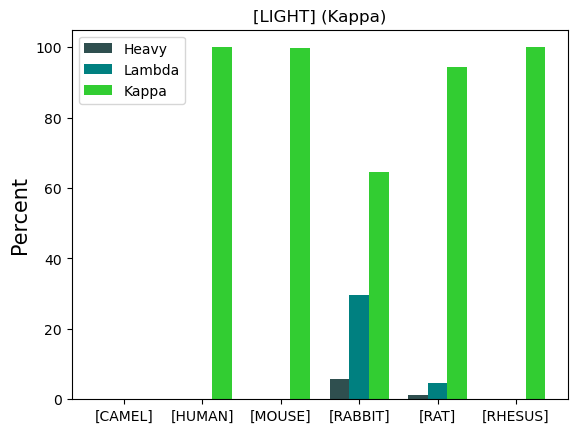

In [735]:
# set width of bar
barWidth = 0.25
fig = plt.subplots()
 
# set height of bar
Heavy = [camel[2][0], human[2][0], mouse[2][0], rabbit[2][0], rat[2][0], rhesus[2][0]]
Lambda = [camel[2][1], human[2][1], mouse[2][1], rabbit[2][1], rat[2][1], rhesus[2][1]]
Kappa = [camel[2][2], human[2][2], mouse[2][2], rabbit[2][2], rat[2][2], rhesus[2][2]]
 
# Set position of bar on X axis
br1 = np.arange(len(Heavy))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
 
# Make the plot
plt.bar(br1, Heavy, color ='darkslategrey', width = barWidth, label ='Heavy')
plt.bar(br2, Lambda, color ='teal', width = barWidth, label ='Lambda')
plt.bar(br3, Kappa, color ='limegreen', width = barWidth, label ='Kappa')
 
# Adding Xticks
plt.ylabel('Percent', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(Heavy))],
        ["[CAMEL]", "[HUMAN]", "[MOUSE]", "[RABBIT]", "[RAT]", "[RHESUS]"])
plt.title('[LIGHT] (Kappa)')
 
plt.legend()
plt.show()

## Checking for complete match: species AND chain type

In [258]:
# Count the number of matching labels

no_count = []  # for sequences not numbered by ANARCI
count_data = np.zeros(len(flattened_seqs))
for i in range(len(anarci_sequences)):    
    if numbering[i] is None:
        no_count.append(anarci_sequences[i][0])
        count_data[i] = np.nan
    else:
        for j in range(len(numbering[i])):
            label = alignment_details[i][j].get("id")
            if (label[0:len(label)-2] in names[i].lower()) & (label[-1] == names[i][-1]):
                count_data[i] = 1
            else:
                count_data[i] = 0
            

In [259]:
## EXAMPLE: indexing the for count_data

# t = 0.6
# i = '[RABBIT]'
# j = 'H'

# if j == 'H':
#     start = names.index(f"{i}0:{t}:{j}")
#     end = names.index(f"{i}1999:{t}:{j}")
# else:
#     start = names.index(f"{i}0:{t}:{j}")
#     end = names.index(f"{i}999:{t}:{j}")
    
# print(start, end)
# np.nanmean(count_data[start:end])

In [260]:
chain_tokens = ['H', 'L', 'K']
species_tokens = ["[HUMAN]", "[MOUSE]", "[RABBIT]", "[RAT]", "[RHESUS]", "[CAMEL]"]
k = 0

perc_correct = np.zeros(len(generated_seqs))
perc_nocount = []

for t in temperature:
    for i in species_tokens:
        for j in chain_types:
            if j == 'H':
                start = names.index(f"{i}0:{t}:{j}")
                end = names.index(f"{i}1999:{t}:{j}")
                perc_correct[k] = np.nanmean(count_data[start:end])
                k += 1
            else:
                if i == "[CAMEL]":
                    continue
                else:
                    start = names.index(f"{i}0:{t}:{j}")
                    end = names.index(f"{i}999:{t}:{j}")
                    perc_correct[k] = np.nanmean(count_data[start:end])
                    k += 1
            
print(perc_correct)

[0.02451226 0.2972973  0.84784785 0.99749875 0.87487487 0.0970971
 1.         0.         0.         0.         0.002002   0.
 0.65332666 0.95895896 0.26526527 0.         0.05852926 0.31031031
 0.80980981 0.99149575 0.87387387 0.08808809 1.         0.
 0.         0.         0.         0.         0.67333667 0.95095095
 0.26426426 0.         0.09154577 0.32532533 0.82282282 0.98549275
 0.86686687 0.12712713 1.         0.         0.         0.
 0.00201207 0.         0.68934467 0.95795796 0.28728729 0.
 0.13383459 0.27983952 0.77577578 0.95597799 0.84854564 0.15245737
 0.99949975 0.         0.00319489 0.         0.00320856 0.01132853
 0.60871743 0.94388778 0.33366733 0.        ]


## Code from ANARCI GitHub

In [90]:
# Each has the same number of elements as the number of sequences submitted
assert len(numbering) == len(alignment_details) == len(hit_tables) == len( anarci_sequences )

# Iterate over the sequences
for i in range(len(anarci_sequences)):    
    if numbering[i] is None:
        print('ANARCI did not number', anarci_sequences[i][0])
    else:
        print('ANARCI numbered', anarci_sequences[i][0])
        print('It identified %d domain(s)'%len(numbering[i]))
        
        # Iterate over the domains
        for j in range(len(numbering[i])):
            domain_numbering, start_index, end_index = numbering[i][j]
            # print('This is the IMGT numbering for the %d\'th domain:'%j, domain_numbering)
            # print('This is the bit of the sequence it corresponds to:', anarci_sequences[i][1][start_index:end_index+1])
            # print('These are the details of the alignment:')
            for (key,value) in alignment_details[i][j].items():
                print(key, ':', value)
            print('This is the summary of the hits that HMMER found')
            for line in hit_tables[i]:
                print(line)      
    print('\n','_'*40)

ANARCI numbered [HUMAN]0:0.6:H
It identified 1 domain(s)
id : alpaca_H
description : 
evalue : 4.9e-64
bitscore : 205.5
bias : 3.8
query_start : 0
query_end : 126
species : alpaca
chain_type : H
scheme : imgt
query_name : [HUMAN]0:0.6:H
This is the summary of the hits that HMMER found
['id', 'description', 'evalue', 'bitscore', 'bias', 'query_start', 'query_end']
['alpaca_H', '', 4.9e-64, 205.5, 3.8, 0, 126]
['human_H', '', 1.9e-60, 193.8, 2.1, 0, 126]
['rhesus_H', '', 1.4e-59, 191.0, 3.0, 0, 126]
['pig_H', '', 5.4e-58, 186.0, 3.9, 0, 126]
['mouse_H', '', 6.4e-56, 179.0, 1.5, 0, 126]
['rabbit_H', '', 4.1e-49, 157.1, 0.8, 2, 126]
['cow_H', '', 2.3e-37, 118.9, 1.3, 1, 126]

 ________________________________________
ANARCI numbered [HUMAN]1:0.6:H
It identified 1 domain(s)
id : alpaca_H
description : 
evalue : 2.2e-63
bitscore : 203.4
bias : 2.1
query_start : 0
query_end : 119
species : alpaca
chain_type : H
scheme : imgt
query_name : [HUMAN]1:0.6:H
This is the summary of the hits that HMM

KeyboardInterrupt: 